In [90]:
import os, pandas as pd, numpy as np
import networkx, scprep, torch, phate
import matplotlib.pyplot as plt
import rpy2, rpy2.situation
from rpy2.robjects import r, pandas2ri

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/home/ferran/PhD/yaleCollab


**Ligand** *(talking)* **-->** **Receptor** *(hearing)* **-->** **Target**[just genes for now] *(listening)*

With the interactions between nodes annotated with lvl3 Reactome pathways.
Build a directed knowledge graph that reflects the structure above.

* L-R interactions from NichetNet & cellchat (or anything else really)
* Target gene list from Nichenet too. 
* Pathways from Reactome. Define receptor/target-pathway edge based on ReactomeDB 

# Pathways

In [3]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

pandas2ri.activate()
%load_ext rpy2.ipython

rpy2 version:
3.5.8
Python version:
3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /home/ferran/miniconda3/envs/collab/lib/R
    Calling `R RHOME`: /home/ferran/miniconda3/envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.2.2 (2022-10-31) -- "Innocent and Trusting"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/home/ferran/miniconda3/envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/home/ferran/miniconda3/envs/collab/lib', '/home/ferran/miniconda3/envs/collab/lib/R/lib', '/home/ferran/miniconda3/envs/collab/lib']
  extra_compile_args:
  ['-std=c99']
  extra_link_args:
  ['-Wl,--export-dynamic', '-fopenmp', '-Wl,-O2', '-Wl,--sort-common', '

In [4]:
#LIst of pathways of interest (2nd level pathways)
dREACTpaths = pd.read_csv(f"{data_dir}/DBs/ReactomePathwaysRelation.txt", sep="\t", header=None)
dREACTpaths = dREACTpaths.loc[dREACTpaths[0].isin([
                "R-HSA-162582",#Signal transduction
                "R-HSA-5357801",#Programmed cell death
                "R-HSA-73894",#DNA repair
                "R-HSA-8953897",#Cell response to stress
                "R-HSA-1500931",#Cell-cell commns
                "R-HSA-1640170"#Cell cycle
                                                    ]),1]
dREACTpaths.shape

(35,)

In [5]:
dREACTpe = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome_PE_All_Levels.txt", sep="\t", header=None)
dREACTpe = dREACTpe.loc[dREACTpe[0].str.startswith("ENSG")|dREACTpe[0].str.startswith("ENSP"),[1,2,3,5]].drop_duplicates()
dREACTpe = dREACTpe.loc[dREACTpe[3].isin(dREACTpaths)]
dREACTpe = dREACTpe.loc[dREACTpe[2].str.match("^\S*[A-Z0-9]+\S*[A-Z0-9]+(\sgene)?(\(\S+\))? \[")][[2,3,5]].dropna().drop_duplicates()
print(dREACTpe[3].nunique())
dREACTpe

35


,2,3,5
1533488,GCLC gene [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1533489,GCLC [cytosol],R-HSA-2262752,Cellular responses to stress
1533535,NFYA [nucleoplasm],R-HSA-2262752,Cellular responses to stress
1533688,CFTR [plasma membrane],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
1533689,CFTR [Golgi-associated vesicle membrane],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
...,...,...,...
2068808,miR-24-2 [cytosol],R-HSA-2262752,Cellular responses to stress
2068823,miR-24-1 [cytosol],R-HSA-2262752,Cellular responses to stress
2070835,ARHGAP11B [cytosol],R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO..."
2075559,NPBWR1 [plasma membrane],R-HSA-372790,Signaling by GPCR


# Ligand-Receptors

In [6]:
%%R -o dNNlr
#Directly load RDS object from NicheNet's zenodo repo
dNNlr = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))

In [7]:
print("Ligand-Receptor\n",dNNlr.describe())
# print("TF-Target\n",dNNgr.describe())
# print("TF-Target 2\n",dNNgrt.shape,dNNgrt)
# print("Ligand-Target\n",dNNlt.shape,dNNlt)
dNNlr

Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304


,from,to,source,database
1,CXCL1,CXCR2,kegg_cytokines,kegg
2,CXCL2,CXCR2,kegg_cytokines,kegg
3,CXCL3,CXCR2,kegg_cytokines,kegg
4,CXCL5,CXCR2,kegg_cytokines,kegg
5,PPBP,CXCR2,kegg_cytokines,kegg
...,...,...,...,...
12647,CXCL6,PIGR,ppi_lr_go,ppi_prediction_go
12648,RLN1,GPR25,ppi_lr_go,ppi_prediction_go
12649,RLN1,RAMP3,ppi_lr_go,ppi_prediction_go
12650,PIK3CB,TNFRSF10A,ppi_bidir_r_go,ppi_prediction_go


In [8]:
dCClr = pd.read_csv(f"{data_dir}/dCellChat_hsapiens.csv.tar.gz",header=None)
dCClr

,0,1,2,3
0,TGFB1,LRinteraction,TGFBR1,TGFb
1,TGFB1,LRinteraction,TGFBR2,TGFb
2,TGFB2,LRinteraction,TGFBR1,TGFb
3,TGFB2,LRinteraction,TGFBR2,TGFb
4,TGFB3,LRinteraction,TGFBR1,TGFb
...,...,...,...,...
1976,VCAM1,LRinteraction,ITGA4,VCAM
1977,VCAM1,LRinteraction,ITGB1,VCAM
1978,VCAM1,LRinteraction,ITGA9,VCAM
1979,VCAM1,LRinteraction,ITGB7,VCAM


In [9]:
dNNlr = pd.DataFrame({
            "head":dNNlr["from"],
            "relation":np.repeat("LR", dNNlr.shape[0]),
            "tail":dNNlr["to"]
        })
dCClr = pd.DataFrame({
            "head":dCClr[0],
            "relation":np.repeat("LR", dCClr.shape[0]),
            "tail":dCClr[2]
        })
dLR = pd.concat([dNNlr, dCClr]).drop_duplicates().reset_index(drop=True)
del dNNlr,dCClr
dLR

,head,relation,tail
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
12927,THY1,LR,ITGB2
12928,THY1,LR,ITGAX
12929,THY1,LR,ITGAV
12930,THY1,LR,ITGB3


# Targets

In [10]:
%%R -o dNNgr
#Directly load RDS object from NicheNet's zenodo repo
dNNgr = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds"))

In [11]:
print("Ligand-Target\n",dNNgr.describe())
dNNgr

Ligand-Target
            from       to              source        database
count   3592299  3592299             3592299         3592299
unique     4486    25103                  20               8
top         YY1   CDKN1A  harmonizome_ENCODE  harmonizome_gr
freq      47472      921             1564116         2953691


,from,to,source,database
1,KLF2,DLGAP1,harmonizome_CHEA,harmonizome_gr
2,KLF2,DTNB,harmonizome_CHEA,harmonizome_gr
3,KLF2,BHLHE40,harmonizome_CHEA,harmonizome_gr
4,KLF2,RPS6KA1,harmonizome_CHEA,harmonizome_gr
5,KLF2,PXN,harmonizome_CHEA,harmonizome_gr
...,...,...,...,...
3592295,ZNF461,CYP19A1,pathwaycommons_controls_expression_of,pathwaycommons_expression
3592296,ZNF467,PPARG,pathwaycommons_controls_expression_of,pathwaycommons_expression
3592297,ZNF521,BGLAP,pathwaycommons_controls_expression_of,pathwaycommons_expression
3592298,ZNF638,PPARG,pathwaycommons_controls_expression_of,pathwaycommons_expression


In [12]:
len(dNNgr["to"].unique())

25103

In [44]:
test0 = dNNgr.loc[dNNgr["from"].isin(dLR["head"])] #Filter to just targets of ligands in KG

test1 = test0.loc[test0["to"]!=test0["from"]] #Filter so that self targets do not count?

test2 = test0.loc[~test0["to"].isin(dLR["head"])&~test0["to"].isin(dLR["tail"])] #Filter so that targets cannot be ligands or receptors

In [45]:
test0

,from,to,source,database
2112465,IL10,ESRRA,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112466,IL10,PNOC,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112467,IL10,WWC1,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112468,IL10,ZBTB43,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112469,IL10,TGFBR1,harmonizome_TRANSFAC_CUR,harmonizome_gr
...,...,...,...,...
3550998,POSTN,CXCL2,pathwaycommons_controls_expression_of,pathwaycommons_expression
3550999,POSTN,ELN,pathwaycommons_controls_expression_of,pathwaycommons_expression
3551000,POSTN,VEGFA,pathwaycommons_controls_expression_of,pathwaycommons_expression
3564738,SEMA4A,VEGFA,pathwaycommons_controls_expression_of,pathwaycommons_expression


In [46]:
test1

,from,to,source,database
2112465,IL10,ESRRA,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112466,IL10,PNOC,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112467,IL10,WWC1,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112468,IL10,ZBTB43,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112469,IL10,TGFBR1,harmonizome_TRANSFAC_CUR,harmonizome_gr
...,...,...,...,...
3550998,POSTN,CXCL2,pathwaycommons_controls_expression_of,pathwaycommons_expression
3550999,POSTN,ELN,pathwaycommons_controls_expression_of,pathwaycommons_expression
3551000,POSTN,VEGFA,pathwaycommons_controls_expression_of,pathwaycommons_expression
3564738,SEMA4A,VEGFA,pathwaycommons_controls_expression_of,pathwaycommons_expression


In [47]:
test2

,from,to,source,database
2112465,IL10,ESRRA,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112467,IL10,WWC1,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112468,IL10,ZBTB43,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112471,IL10,ABLIM1,harmonizome_TRANSFAC_CUR,harmonizome_gr
2112473,IL10,PPP2R2B,harmonizome_TRANSFAC_CUR,harmonizome_gr
...,...,...,...,...
3514891,LCK,MYC,pathwaycommons_controls_expression_of,pathwaycommons_expression
3514893,LCK,SOCS3,pathwaycommons_controls_expression_of,pathwaycommons_expression
3550995,POSTN,ACTA2,pathwaycommons_controls_expression_of,pathwaycommons_expression
3550999,POSTN,ELN,pathwaycommons_controls_expression_of,pathwaycommons_expression


Carry on with the strictest subset, but interesting discussion on what to do next.

In [48]:
len(test2["to"].unique())

11519

# KG assembly

* Set of triples from L-R database:
    * Replicate triples for as many pathways are found to contain both Ligand and Receptor entities
* Set of triples from R-PTMs:
    * If Receptor and PTM in the same pathway, define triple with pathway edge annotation.


In [19]:
#Make df with only gene names. Group by pathway. IF both L and R in same group, we have a hit!
mdPathPE = dREACTpe.copy(deep=True)
mdPathPE[2] = mdPathPE[2].str.extract("^([A-Z0-9]+-*[A-Z0-9]+)")[0]
mdPathPE = mdPathPE.dropna().drop_duplicates()
mdPathPE = mdPathPE.groupby(by=[5])
mdPathPE.describe()

2                       \
                                                   count unique      top freq   
5                                                                               
Apoptosis                                            173    173      BAD    1   
Base Excision Repair                                  75     75     LIG3    1   
Cell Cycle Checkpoints                               259    259   MAD1L1    1   
Cell Cycle, Mitotic                                  518    518   MAD1L1    1   
Cell junction organization                            91     91   CLDN11    1   
Cellular responses to stress                         757    757     GCLC    1   
Chromosome Maintenance                               119    119   POLR2J    1   
DNA Damage Bypass                                     51     51    REV3L    1   
DNA Damage Reversal                                    8      8   ALKBH5    1   
DNA Double-Strand Break Repair                       153    153    RAD52    1   
Death Receptor Signalling                            148    148      BAD    1   
Fanconi Anemia Pathway                                38     38    ERCC1    1   
Integrin signaling                                    26     26   ITGA2B    1   
Intracellular signaling by second messengers         282    282      BAD    1   
MAPK family signaling cascades                       290    290   ITGA2B    1   
MTOR signalling                                       39     39    RRAGD    1   
Meiosis                                               85     85    BRCA1    1   
Mismatch Repair                                       15     15    POLD1    1   
Nephrin family interactions                           23     23      FYN    1   
Nucleotide Excision Repair                           120    120   POLR2J    1   
Regulated Necrosis                                    57     57    CFLAR    1   
Response to metal ions                                14     14     SNCB    1   
Signal regulatory protein family interactions         16     16    SKAP2    1   
Signaling by Erythropoietin                           22     22   PIK3CB    1   
Signaling by GPCR                                    693    693    WNT16    1   
Signaling by Hedgehog                                157    157  PRKAR2B    1   
Signaling by Hippo                                    20     20     DVL2    1   
Signaling by Leptin                                   11     11     JAK2    1   
Signaling by NOTCH                                   216    216   PLXND1    1   
Signaling by Non-Receptor Tyrosine Kinases            49     49    BCAR1    1   
Signaling by Nuclear Receptors                       258    258  CYP26B1    1   
Signaling by Receptor Tyrosine Kinases               509    509   POLR2J    1   
Signaling by Rho GTPases, Miro GTPases and RHOBTB3   679    679     CFTR    1   
Signaling by TGFB family members                     119    119    WWTR1    1   
Signaling by WNT                                     298    298      N4G    1   

                                                       3         \
                                                   count unique   
5                                                                 
Apoptosis                                            173      1   
Base Excision Repair                                  75      1   
Cell Cycle Checkpoints                               259      1   
Cell Cycle, Mitotic                                  518      1   
Cell junction organization                            91      1   
Cellular responses to stress                         757      1   
Chromosome Maintenance                               119      1   
DNA Damage Bypass                                     51      1   
DNA Damage Reversal                                    8      1   
DNA Double-Strand Break Repair                       153      1   
Death Receptor Signalling                            148      1   
Fanconi Anemia Pathway                

In [ ]:
# %%time
# dLRpath = pd.DataFrame(columns=["head","relation","tail"])
# for i in dLR.iterrows():
#     for name, group in mdPathPE:
#         if any(group[2].str.contains(i[1]["head"])):
#             if any(group[2].str.contains(i[1]["tail"])):
#                 row = pd.Series({"head":i[1]["head"], "relation":name, "tail":i[1]["tail"]})
#                 dLRpath = pd.concat([dLRpath, row.to_frame().T])
# dLRpath = dLRpath.reset_index(drop=True)
# dLRpath.to_csv(f"{data_dir}/dLRpath.csv.tar.gz", index=False)

CPU times: user 4min 20s, sys: 4.95 ms, total: 4min 20s
Wall time: 4min 20s


In [20]:
dLRpath = pd.read_csv(f"{data_dir}/dLRpath.csv.tar.gz")

In [21]:
dLRpath

,head,relation,tail
0,CXCL1,Signaling by GPCR,CXCR2
1,CXCL2,Signaling by GPCR,CXCR2
2,CXCL3,Signaling by GPCR,CXCR2
3,CXCL5,Signaling by GPCR,CXCR2
4,PPBP,Signaling by GPCR,CXCR2
...,...,...,...
9613,LAMA3,Cell junction organization,ITGB4
9614,LAMB3,Cell junction organization,ITGB4
9615,VWF,MAPK family signaling cascades,GP
9616,CDH1,Cell junction organization,ITGB1


Ingredients:

- List of targets from test2["to"]
- List of receptors from dLRpath["tail"]
- Genes grouped into pathways

Desire:

- If any combination of target and receptor belongs to the same pathway group, store the receptor, target and pathway name information


In [49]:
print(len(test2["to"].unique()))
print(len(dLRpath["tail"].unique()))

11519
413


In [53]:
%%time
dRTpath = pd.DataFrame(columns=["head","relation","tail"])

for name, group in mdPathPE:
    if any(test2["to"].isin(group[2])) & any(dLRpath["tail"].isin(group[2])):
        for r in group.loc[group[2].isin(dLRpath["tail"])][2].unique():
            for t in group.loc[group[2].isin(test2["to"])][2].unique():
                row = pd.Series({"head":r, "relation":name, "tail":t})
                dRTpath = pd.concat([dRTpath, row.to_frame().T])
        print(name)

dRTpath = dRTpath.dropna().drop_duplicates().reset_index(drop=True)
dRTpath.to_csv(f"{data_dir}/dRTpath.csv.tar.gz", index=False)

Apoptosis
Cell junction organization
Cellular responses to stress
Death Receptor Signalling
Integrin signaling
Intracellular signaling by second messengers
MAPK family signaling cascades
Nephrin family interactions
Regulated Necrosis
Signal regulatory protein family interactions
Signaling by Erythropoietin
Signaling by GPCR
Signaling by Hedgehog
Signaling by NOTCH
Signaling by Non-Receptor Tyrosine Kinases
Signaling by Nuclear Receptors
Signaling by Receptor Tyrosine Kinases
Signaling by Rho GTPases, Miro GTPases and RHOBTB3
Signaling by TGFB family members
Signaling by WNT
CPU times: user 2min 2s, sys: 39.7 ms, total: 2min 2s
Wall time: 2min 2s


In [54]:
dRTpath = pd.read_csv(f"{data_dir}/dRTpath.csv.tar.gz")

In [55]:
dRTpath

,head,relation,tail
0,FAS,Apoptosis,BAD
1,FAS,Apoptosis,CFLAR
2,FAS,Apoptosis,PSMB1
3,FAS,Apoptosis,PSMC4
4,FAS,Apoptosis,BID
...,...,...,...
87623,LGR4,Signaling by WNT,HIST1H2BO
87624,LGR4,Signaling by WNT,HIST1H2BH
87625,LGR4,Signaling by WNT,PSMB3
87626,LGR4,Signaling by WNT,HIST1H2BB


Assemble

In [57]:
dKGlrt = pd.concat([dLRpath, dRTpath]).drop_duplicates().reset_index(drop=True)

In [58]:
dKGlrt.to_csv(f"{data_dir}/dKGlrt.csv.tar.gz", index=False, header=False)

In [59]:
dKGlrt = pd.read_csv(f"{data_dir}/dKGlrt.csv.tar.gz", header=None)
dKGlrt

,0,1,2
0,CXCL1,Signaling by GPCR,CXCR2
1,CXCL2,Signaling by GPCR,CXCR2
2,CXCL3,Signaling by GPCR,CXCR2
3,CXCL5,Signaling by GPCR,CXCR2
4,PPBP,Signaling by GPCR,CXCR2
...,...,...,...
97241,LGR4,Signaling by WNT,HIST1H2BO
97242,LGR4,Signaling by WNT,HIST1H2BH
97243,LGR4,Signaling by WNT,PSMB3
97244,LGR4,Signaling by WNT,HIST1H2BB


# KG networks

### As a multigraph in networtkX

Just to make degree plots

In [61]:
G = networkx.from_pandas_edgelist(
    dKGlrt,
    source=0,target=2,
    edge_key=1,
    edge_attr=1,
    create_using=networkx.MultiGraph())
G

In [88]:
print(f"Edges:{G.number_of_edges()}, Nodes:{G.number_of_nodes()}, Avg Degree:{sum(dict(G.degree()).values())/G.number_of_nodes()}")

Edges:97243, Nodes:2505, Avg Degree:77.63912175648703


In [87]:
print(f"Density of {networkx.density(G)}")
print("We have this many isolates: ", 
        networkx.number_of_isolates(G))
print("The graph is connected:",
        networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: Density of {networkx.density(g)}")
        print(f"Edges:{g.number_of_edges()}, Nodes:{g.number_of_nodes()}, Avg Degree:{sum(dict(g.degree()).values())/g.number_of_nodes()}")

Density of 0.031006039040130603
We have this many isolates:  0
The graph is connected: False

We have 5 connected subgraphs
Component 1: Density of 0.031227197985715018
Edges:97234, Nodes:2496, Avg Degree:77.91185897435898
Component 2: Density of 1.0
Edges:1, Nodes:2, Avg Degree:1.0
Component 3: Density of 2.0
Edges:6, Nodes:3, Avg Degree:4.0
Component 4: Density of 1.0
Edges:1, Nodes:2, Avg Degree:1.0
Component 5: Density of 1.0
Edges:1, Nodes:2, Avg Degree:1.0


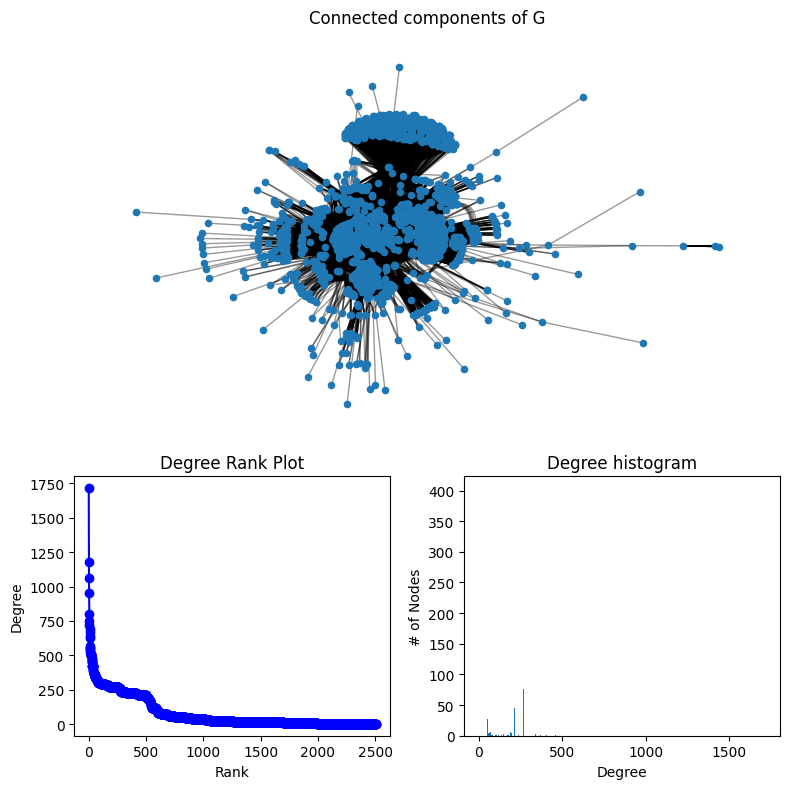

In [91]:
#Degree analysis: For directed graph it's the full graph -> no connected
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(networkx.connected_components(G), key=len, reverse=True)[0])
pos = networkx.spring_layout(Gcc, seed=10396953)
networkx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
networkx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

### As a multidigraph in NetworkX
Directed multigraph

In [92]:
G = networkx.from_pandas_edgelist(
    dKGlrt,
    source=0,target=2,
    edge_key=1,
    edge_attr=1,
    create_using=networkx.MultiDiGraph())
G

In [93]:
print(f"Edges:{G.number_of_edges()}, Nodes:{G.number_of_nodes()}, Avg Degree:{sum(dict(G.degree()).values())/G.number_of_nodes()}")
print("We have this many isolates: ", 
        networkx.number_of_isolates(G))

Edges:97246, Nodes:2505, Avg Degree:77.64151696606787
We have this many isolates:  0


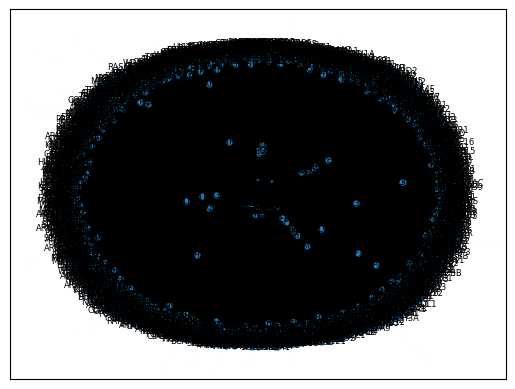

In [96]:
networkx.draw_networkx(G, node_size=12, font_size=6)

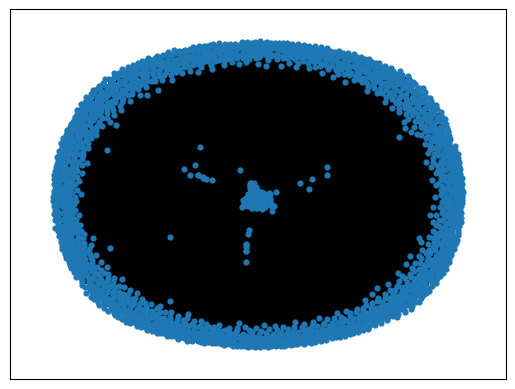

In [98]:
networkx.draw_networkx(G, node_size=12, font_size=6, with_labels=False)